In this notebook, I test if the SDXL weights I'm using produce sesible results with diffuers. If not, the weights might be broken.

In [1]:
#!pip install -Uqq transformers diffusers 

In [2]:
import torch

In [3]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionXLPipeline

In [4]:
model = "stabilityai/stable-diffusion-xl-base-1.0"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae", torch_dtype=torch.float16)

In [5]:
pipe = StableDiffusionXLPipeline.from_pretrained(model, vae=vae, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
#pipe = pipe.to('cuda')

In [ ]:
prompt  = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
nprompt = 'lowres, bad anatomy, worst quality, low quality'
size = 8*(756//8)

In [ ]:
im = pipe(prompt, width=size, height=size, negative_prompt=nprompt)[0]

In [ ]:
im[0]

In [ ]:
im = pipe(prompt, width=size, height=size, negative_prompt=nprompt, num_inference_steps=10)[0]

In [ ]:
im[0]

___

Let's doodle around with SDXL

In [6]:
from util import public_attrs

In [7]:
unet = pipe.unet
type(unet)

diffusers.models.unet_2d_condition.UNet2DConditionModel

In [8]:
def class_names(modules): return [m.__class__.__name__ for m in modules]

In [9]:
class_names(unet.down_blocks)

['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']

In [10]:
class_names(unet.up_blocks)

['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']

In [11]:
unet.time_embedding

TimestepEmbedding(
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
)

In [12]:
unet.time_embedding.linear_2.out_features

1280

In [13]:
type(unet.encoder_hid_proj)

NoneType

In [14]:
unet.down_blocks[1].attentions[0]

Transformer2DModel(
  (norm): GroupNorm(32, 640, eps=1e-06, affine=True)
  (proj_in): LoRACompatibleLinear(in_features=640, out_features=640, bias=True)
  (transformer_blocks): ModuleList(
    (0-1): 2 x BasicTransformerBlock(
      (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_k): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_v): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_out): ModuleList(
          (0): LoRACompatibleLinear(in_features=640, out_features=640, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (attn2): Attention(
        (to_q): LoRACompatibleLinear(in_features=640, out_features=640, bias=False)
        (to_k): LoRACompatibleLinear(in_features=2048, out_features=640,

In [15]:
unet.down_blocks[1].attentions[0].transformer_blocks[0].attn1.to_k.in_features

640

In [16]:
def cross_attn_input_size(b,a,t):
    net = unet.down_blocks[b].attentions[a].transformer_blocks[t]
    return net.attn1.to_k.in_features,net.attn2.to_k.in_features

In [17]:
for d in (1,2):
    for a in (0,1):
        for t in range(10):
            if d!=2 and t>=2: continue
            s1,s2=cross_attn_input_size(d,a,t)
            print(f'{d},{a},{t} -> {s1} | {s2}')

1,0,0 -> 640 | 2048
1,0,1 -> 640 | 2048
1,1,0 -> 640 | 2048
1,1,1 -> 640 | 2048
2,0,0 -> 1280 | 2048
2,0,1 -> 1280 | 2048
2,0,2 -> 1280 | 2048
2,0,3 -> 1280 | 2048
2,0,4 -> 1280 | 2048
2,0,5 -> 1280 | 2048
2,0,6 -> 1280 | 2048
2,0,7 -> 1280 | 2048
2,0,8 -> 1280 | 2048
2,0,9 -> 1280 | 2048
2,1,0 -> 1280 | 2048
2,1,1 -> 1280 | 2048
2,1,2 -> 1280 | 2048
2,1,3 -> 1280 | 2048
2,1,4 -> 1280 | 2048
2,1,5 -> 1280 | 2048
2,1,6 -> 1280 | 2048
2,1,7 -> 1280 | 2048
2,1,8 -> 1280 | 2048
2,1,9 -> 1280 | 2048


In [18]:
def attn_bias(b,a,t): return unet.down_blocks[b].attentions[a].transformer_blocks[t].attn1.to_k.bias is not None

In [19]:
for d in (1,2):
    for a in (0,1):
        for t in range(10):
            if d!=2 and t>=2: continue
            b=attn_bias(d,a,t)
            print(f'{d},{a},{t} -> {b}')

1,0,0 -> False
1,0,1 -> False
1,1,0 -> False
1,1,1 -> False
2,0,0 -> False
2,0,1 -> False
2,0,2 -> False
2,0,3 -> False
2,0,4 -> False
2,0,5 -> False
2,0,6 -> False
2,0,7 -> False
2,0,8 -> False
2,0,9 -> False
2,1,0 -> False
2,1,1 -> False
2,1,2 -> False
2,1,3 -> False
2,1,4 -> False
2,1,5 -> False
2,1,6 -> False
2,1,7 -> False
2,1,8 -> False
2,1,9 -> False


___

### Let's save the model and reload it from locally saved weights

In [31]:
pipe.save_pretrained('weights/sdxlvae')

In [2]:
assert False

AssertionError: 

Restart kernel now

___

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline

In [2]:
pipe = StableDiffusionXLPipeline.from_pretrained('weights/sdxlvae').to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
prompt  = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
nprompt = 'lowres, bad anatomy, worst quality, low quality'
size = 8*(756//8)

  0%|          | 0/50 [00:00<?, ?it/s]

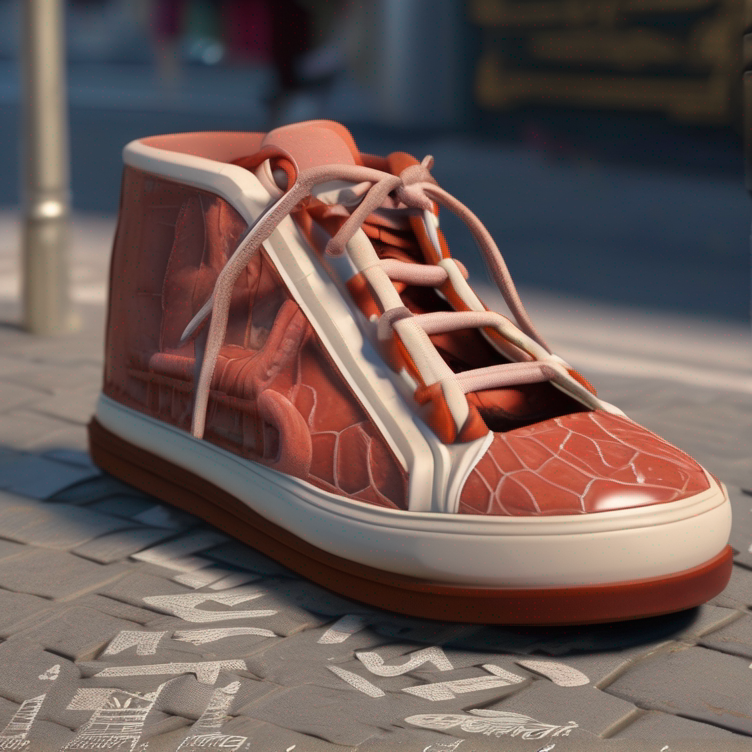

In [5]:
pipe(prompt, width=size, height=size, negative_prompt=nprompt, num_inference_steps=50)[0][0]